In [1]:
import fitsio

import numpy as np
from scipy.optimize import curve_fit
from astropy.table import Table
from astropy.io import fits
from astropy.cosmology import Planck18
from astropy.constants import iau2015 as const
from astropy import units as u
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import MultipleLocator

from fitting import get_phis

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
# settings

zmin, zmax = 2.3, 2.8
#zmin, zmax = 2.0, 3.0
#ramin, ramax, decmin, decmax, frac_area = 0., 360., -90., 90., 0.16
ramin, ramax, decmin, decmax, frac_area = 140., 220., -3., 4., 0.014
band, magmin, magmax = "R", 18., 23.
#band, magmin, magmax = "G", 18., 24.

skyarea = 4 * np.pi * (180 / np.pi) ** 2 # 41253 deg2


# mag shift to convert bolometric absmag to per-band absmag
# fig. 2 of Shen+20:
# log10(L_bol / L_band) ~ 0.7 for 1450A
# log10(L_bol) - log10(L_band) = 0.7
# -2.5 * (log10(L_bol) - log10(L_band)) = -2.5 * 0.7 = -1.75
# M_bol - M_band = -1.75
# M_band = M_bol + 1.75
M_bol2band = -1.75
#M_bol2band = -1.

# not using np.arange(), as e.g. np.arange(2.3, 2.8, 0.1) stops at 2.7 and np.arange(2.3, 2.9, 0.1) stops at 2.9...
dz = 0.1
#dz = 1.0
zbins = np.array([zmin + i * dz for i in range(1000) if zmin + i * dz <= zmax]).round(2)
zcens = 0.5 * (zbins[1:] + zbins[:-1]).round(3)

dmag = 0.25
#dmag = 0.1
magbins = np.array([magmin + i * dmag for i in range(1000) if magmin + i * dmag <= magmax]).round(2)
# just one bin below 18 mag, because poor stats
magbins = np.array([_ for _ in magbins if (_ == magmin) | (_ >= 18)])
# take the middle *flux* in each bin
fluxbins = 10 ** (-0.4 * (magbins - 22.5))
fluxcens = 0.5 * (fluxbins[1:] + fluxbins[:-1])
magcens = (22.5 - 2.5 * np.log10(fluxcens)).round(2)

print("(zmin, zmax) = ({}, {})".format(zmin, zmax))
print("(ramin, ramax, decmin, decmax, frac_area) = ({}, {}, {}, {}, {})".format(ramin, ramax, decmin, decmax, frac_area))
print("zbins = {}".format(zbins.tolist()))
print("magbins = {}".format(magbins.tolist()))

(zmin, zmax) = (2.3, 2.8)
(ramin, ramax, decmin, decmax, frac_area) = (140.0, 220.0, -3.0, 4.0, 0.014)
zbins = [2.3, 2.4, 2.5, 2.6, 2.7, 2.8]
magbins = [18.0, 18.25, 18.5, 18.75, 19.0, 19.25, 19.5, 19.75, 20.0, 20.25, 20.5, 20.75, 21.0, 21.25, 21.5, 21.75, 22.0, 22.25, 22.5, 22.75, 23.0]


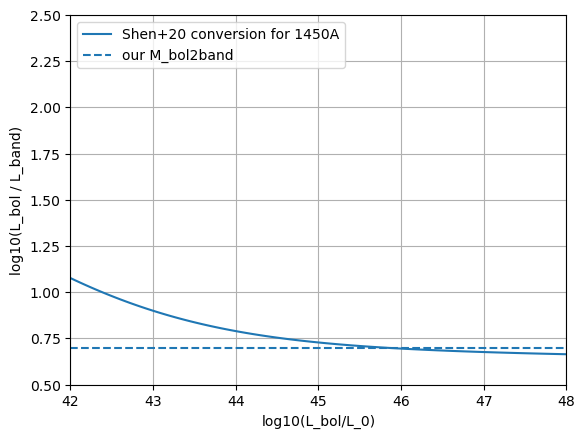

In [3]:
L_0 = const.L_bol0.to(u.erg / u.s).value
L_sun = const.L_sun.to(u.erg / u.s).value

# few utility functions
def abs_mag_to_L(M):
    L = L_0 * 10.0 ** (-0.4 * M)
    return L

def L_to_abs_mag(L):
    M = -2.5 * np.log10(L / L_0)
    return M

def appmag_to_absmag_bol(app_mag, dist_mod, band2bol):
    return app_mag - dist_mod + band2bol

# eq. 5 + tab. 1 of Shen+20
# taking the 1450 A case, not very far from g-band at z~2.5...
#  even though we use r-band..
def L_bol2band(L_bol):
    c1, k1, c2, k2 = 1.862, -0.361, 4.870, -0.0063
    L_band = L_bol / (
        c1 * (L_bol / (10 ** 10 * L_sun)) ** k1
        +
        c2 * (L_bol / (10 ** 10 * L_sun)) ** k2
    )
    return L_band


# reverse...
L_bol2band_dict = {}
L_bol2band_dict["L_bol"] = np.logspace(42, 50, 1000)
L_bol2band_dict["L_band"] = L_bol2band(L_bol2band_dict["L_bol"])
def L_band2bol(L_band):
    if (L_band.min() < L_bol2band_dict["L_band"].min()) | (L_band.max() > L_bol2band_dict["L_band"].max()):
        raise ValueError(
            "L_band (min, max) = ({}, {}) out of ({}, {}) range".format(
                   L_band.min(), L_band.max(), L_bol2band_dict["L_band"].min(), L_bol2band_dict["L_band"].max(),
                )
            )
    L_bol = np.interp(L_band, L_bol2band_dict["L_band"], L_bol2band_dict["L_bol"])
    return L_bol


def appmag2Lbol(appmags, z):
    dist_mod = Planck18.distmod(z).value
    absmag_band = appmags - dist_mod
    L_band = abs_mag_to_L(absmag_band)
    L_bol = L_band2bol(L_band)
    return L_bol

def Lbol2appmag(L_bol, z):
    dist_mod = Planck18.distmod(z).value
    L_band = L_bol2band(L_bol)
    absmag_band = L_to_abs_mag(L_band)
    appmags = absmag_band + dist_mod
    return appmags


            
# add L_bol top-axis
# ax: x-axis is apparent magnitudes
#     need ax.set_xlim() to have been run before!
def add_L_bol_axis(ax, z):
    xticks = ax.get_xticks()
    xticklabels = np.log10(appmag2Lbol(xticks, z)).round(1)
    axtwiny = ax.twiny()
    axtwiny.set_xlim(ax.get_xlim())
    axtwiny.set_xticks(xticks)
    axtwiny.set_xticklabels(xticklabels)
    axtwiny.set_xlabel("log10(L_bol [erg/s])")


# check L_bol2band (should look like top panel of fig. 2 of Shen+20)
L_bols = np.logspace(42, 48, 100)
L_bands = L_bol2band(L_bols)
fig, ax = plt.subplots()
ax.plot(np.log10(L_bols), np.log10(L_bols / L_bands), label="Shen+20 conversion for 1450A")
ax.axhline(-0.4 * M_bol2band, ls="--", label="our M_bol2band")
ax.set_xlabel("log10(L_bol/L_0)")
ax.set_ylabel("log10(L_bol / L_band)")
ax.set_xlim(42, 48)
ax.set_ylim(0.5, 2.5)
ax.grid()
ax.legend(loc=2)
plt.show()


In [4]:
# function to read the data
def read_data(zmin, zmax, ramin, ramax, decmin, decmax, band, magmin, magmax):

    # read data
    #fn = "/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits"
    #========================
    fn = "/global/cfs/cdirs/desi/survey/catalogs/Y1/QSO/iron/QSO_cat_iron_main_dark_healpix_only_qso_targets_v0.fits"
    d = Table(fitsio.read(fn))
    d["APP_MAG_G"] = 22.5 - 2.5 * np.log10(d["FLUX_G"]) - 3.214 * d["EBV"]
    d["APP_MAG_R"] = 22.5 - 2.5 * np.log10(d["FLUX_R"]) - 1.265 * d["EBV"]
    #========================
    """
    assert (zmin >= 2.3) & (zmin <= 2.8)
    assert (zmax >= 2.3) & (zmax <= 2.8)
    sel = (d["Z"] > zmin) & (d["Z"] < zmax)
    d = d[sel]
    fn = "/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k.csv"
    k = Table.read(fn, format="csv")
    # hopefully, d and k should be row-matched here...
    assert len(d) == len(k)
    d["K_CORR_G"], d["K_CORR_R"] = k["k_gg"], k["k_rr"]
    print("read {} rows in 2.3 < z < 2.8".format(len(d)))
    """
    
    # remove duplicates
    _, ii = np.unique(d["TARGETID"], return_index=True)
    d = d[ii]
    print("keep {} rows after removing duplicates".format(len(d)))

    # make selection on z, radec, magnitude
    sel = np.ones(len(d), dtype=bool)
    #sel &= (np.isfinite(d["K_CORR_{}".format(band)])) & (np.isfinite(d["K_CORR_{}".format(band)]))
    #print("keep {} rows after cutting on finite K_CORR_{}".format(sel.sum(), band))
    sel &= (d["Z"] > zmin) & (d["Z"] < zmax)
    print("keep {} rows after cutting on {} < z < {}".format(sel.sum(), zmin, zmax))
    sel &= (d["TARGET_RA"] > ramin) & (d["TARGET_RA"] < ramax)
    sel &= (d["TARGET_DEC"] > decmin) & (d["TARGET_DEC"] < decmax)
    print("keep {} rows after cutting on {} < ra < {}, {} < dec < {}".format(sel.sum(), ramin, ramax, decmin, decmax))
    sel &= (d["APP_MAG_{}".format(band)] > magmin) & (d["APP_MAG_{}".format(band)] < magmax)
    print("keep {} rows after cutting on {} < mag_{} < {}".format(sel.sum(), magmin, band.lower(), magmax))
    d = d[sel]
    
    # comoving distance
    d["DIST_MOD"] = Planck18.distmod(d["Z"]).value

    return d

In [5]:
# function to fit the ratio n(data) / n(shen+20)
def myfunc(xs, x0, b):
    ys = np.ones(len(xs))
    sel = xs > x0
    ys[sel] = (xs[sel] / x0) ** (-b)
    return ys

# keys, initial guess, boundaries
fit_keys = ["X0", "B"]
p0 = (18, 1)
bounds = (
    (17, 0.0),
    (21, 20),
)

In [6]:
def plot_data(d, frac_area, magmin, magmax, dmag, zbins, dz):
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(2, 2, wspace=0.4, hspace=0.2)

    # check the sky distribution
    npt = 10000
    if len(d) > npt:
        ii = np.random.choice(len(d), size=npt, replace=False)
    else:
        ii = np.arange(len(d), dtype=int)
    ax = plt.subplot(gs[0])
    ax.scatter(d["TARGET_RA"][ii], d["TARGET_DEC"][ii], alpha=0.25)
    ax.set_xlabel("R.A. [deg]")
    ax.set_ylabel("Dec. [deg]")
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.grid()

    # efftime_spec
    bins = np.linspace(0, 5000, 100)
    ax = plt.subplot(gs[1])
    _ = ax.hist(12.15 * d["TSNR2_LRG"], bins=bins, density=True)
    ax.set_xlabel("EFFTIME_SPEC [s]")
    ax.set_ylabel("Norm. ounts")
    ax.grid()
    
    # check the per-redshift app_mag distribution
    for ip, weights, density, ylabel, ylim, ymloc in zip(
        [2, 3],
        [
            np.ones(len(d)) / (frac_area * skyarea * dmag * dz), # 1 / area / dmag / dz
            np.ones(len(d)),
        ],
        [False, True],
        ["Obs. QSO counts [/deg2/dmag/dz]", "Obs. QSO norm. counts"],
        [(0, 50), (0, 1)],
        [5, 0.1],
    ):
        ax = plt.subplot(gs[ip])
        for i in range(len(zbins) - 1):
            sel = (d["Z"] >= zbins[i]) & (d["Z"] < zbins[i+1])
            _ = ax.hist(d["APP_MAG_{}".format(band)][sel], weights=weights[sel], bins=magbins, density=density, histtype="step", label="{} < z < {} ({} qsos)".format(zbins[i], zbins[i+1], sel.sum()))
        ax.set_xlabel("APP_MAG_{} [AB]".format(band))
        ax.set_ylabel(ylabel)
        ax.set_xlim(magmin - dmag, magmax + dmag)
        ax.set_ylim(ylim)
        ax.xaxis.set_major_locator(MultipleLocator(1.0))
        ax.yaxis.set_major_locator(MultipleLocator(ymloc))
        ax.grid()

        # tables 6,7 from Palanque-Delabrouille+16 (erratum)
        # https://www.aanda.org/articles/aa/pdf/2016/05/aa27392e-15.pdf
        # pick the z=2.5 column; that s for 10k deg2
        pd16_area = 1e4 # 10k deg2
        pd16_dmag = 0.5
        pd16_dz = 1.0
        if band == "G":
            pd16_mags = np.array([15.75, 16.25, 16.75, 17.25, 17.75, 18.25, 18.75, 19.25, 19.75, 20.25, 20.75, 21.25, 21.75, 22.25, 22.75, 23.25, 23.75, 24.25, 24.75])
            pd16_ple = np.array([10, 33, 87, 231, 626, 1727, 4780, 12319, 26357, 45742, 68898, 95351, 125298, 159894, 201144, 251597, 314273, 392821, 491772], dtype=float)
            pd16_ple_lede = np.array([1, 5, 20, 76, 287, 1065, 3737, 11415, 27445, 50511, 76197, 103193, 133441, 169698, 214695, 271321, 342970, 433845, 549267], dtype=float)
        if band == "R":
            pd16_mags = np.array([15.75, 16.25, 16.75, 17.25, 17.75, 18.25, 18.75, 19.25, 19.75, 20.25, 20.75, 21.25, 21.75, 22.25, 22.75, 23.25, 23.75])
            pd16_ple = np.array([14, 41, 108, 290, 793, 2204	, 5994	, 14675, 29834, 50203, 74188, 101326, 132051, 167766, 210616, 263236, 328743], dtype=float)
            pd16_ple_lede = np.array([2, 8, 29, 109, 407, 1476, 4934, 14012, 31432, 55189, 81153, 108661, 139912, 177682, 224720, 283998, 359048], dtype=float)
        # normalize to area and dmag and dz
        pd16_ple /= (pd16_area * pd16_dmag * pd16_dz)
        pd16_ple_lede /= (pd16_area * pd16_dmag * pd16_dz)
        # overall normalization
        if density:
            if band == "G":
                sel = (pd16_mags >= magmin) & (pd16_mags <= magmax)
            if band == "R":
                sel = (pd16_mags >= magmin) & (pd16_mags <= magmax + 0.5) # small hack...
            pd16_mags, pd16_ple, pd16_ple_lede = pd16_mags[sel], pd16_ple[sel], pd16_ple_lede[sel]
            pd16_ple /= (pd16_ple.sum() * dmag)
            pd16_ple_lede /= (pd16_ple_lede.sum() * dmag)
        ax.plot(pd16_mags, pd16_ple, ls="--", label="PD16 PLE {}-band at z=2.5".format(band.lower()))
        ax.plot(pd16_mags, pd16_ple_lede, ls="--", label="PD16 PLE+LEDE {}-band at z=2.5".format(band.lower()))

        # eye-balled linear extrapolation
        #if ip == 2:
        if False:
            sel = magbins >= 21
            ax.plot(magbins[sel] , 0.3 + 0.2* (magbins[sel] - 21), color="k", ls="--", label="y = 0.3 + 0.2 * (x - 21)")

        ax.legend(loc=2)

    plt.show()

keep 1470434 rows after removing duplicates
keep 190925 rows after cutting on 2.3 < z < 2.8
keep 14807 rows after cutting on 140.0 < ra < 220.0, -3.0 < dec < 4.0
keep 14661 rows after cutting on 18.0 < mag_r < 23.0
['TARGETID', 'Z', 'ZERR', 'ZWARN', 'SPECTYPE', 'COADD_FIBERSTATUS', 'TARGET_RA', 'TARGET_DEC', 'MORPHTYPE', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 'PROBA_RF', 'MASKBITS', 'DESI_TARGET', 'SCND_TARGET', 'COADD_NUMEXP', 'COADD_EXPTIME', 'CMX_TARGET', 'SV1_DESI_TARGET', 'SV2_DESI_TARGET', 'SV3_DESI_TARGET', 'SV1_SCND_TARGET', 'SV2_SCND_TARGET', 'SV3_SCND_TARGET', 'TSNR2_LYA', 'TSNR2_QSO', 'DELTA_CHI2_MGII', 'A_MGII', 'SIGMA_MGII', 'B_MGII', 'VAR_A_MGII', 'VAR_SIGMA_MGII', 'VAR_B_MGII', 'Z_RR', 'Z_QN', 'C_LYA', 'C_CIV', 'C_CIII', 'C_MgII', 'C_Hbeta', 'C_Halpha', 'Z_LYA', 'Z_CIV',

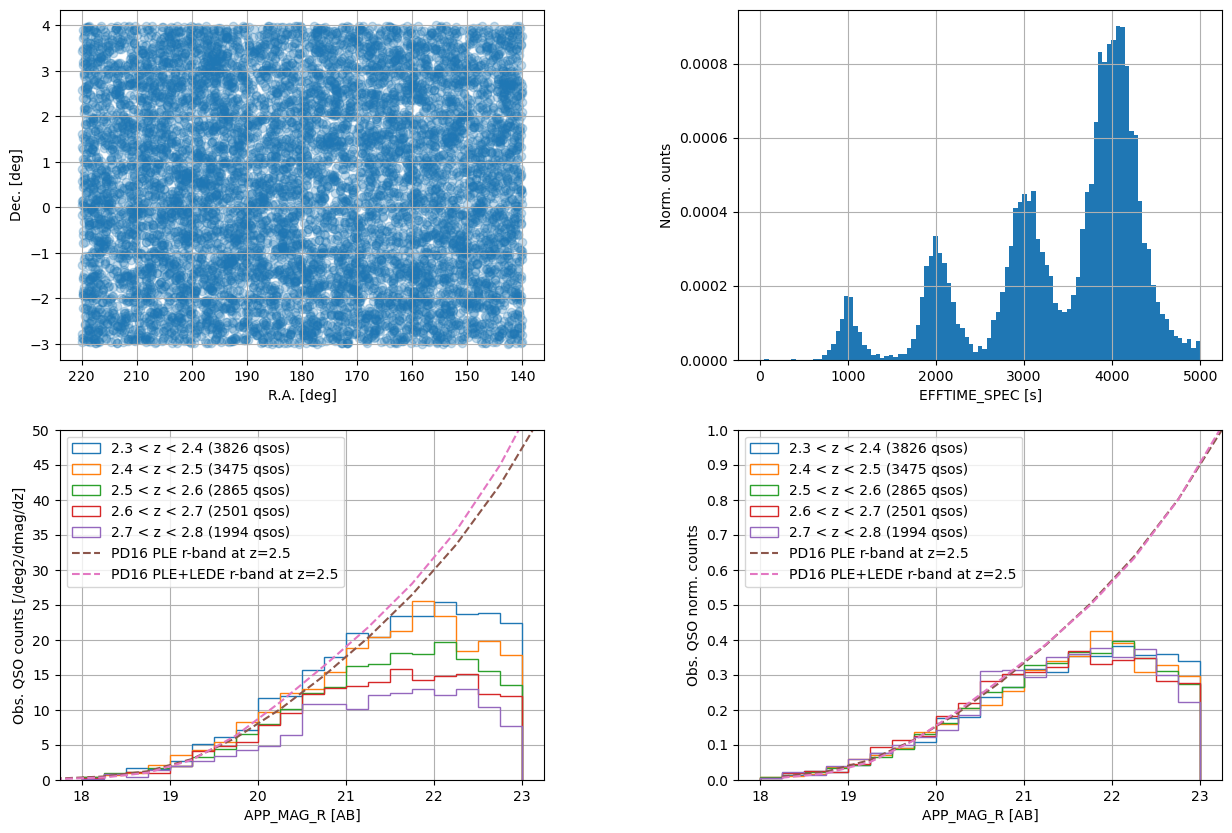

In [7]:
d = read_data(zmin, zmax, ramin, ramax, decmin, decmax, band, magmin, magmax)
print(d.colnames)
#d.write("/global/cfs/cdirs/desi/users/raichoor/tmpdir/tmp.fits", overwrite=True)
plot_data(d, frac_area, magmin, magmax, dmag, zbins, dz)

In [8]:
# data qso counting
# (nzbin, nmagbin) array
data_n, _, _ = np.histogram2d(d["Z"], d["APP_MAG_{}".format(band)], bins=[zbins, magbins])
print("data_n.shape = {}".format(data_n.shape))

# poissonian errors
err_data_n = np.sqrt(data_n)

data_n.shape = (5, 20)


shell_vol.shape = (5,)

2.3 < z < 2.4


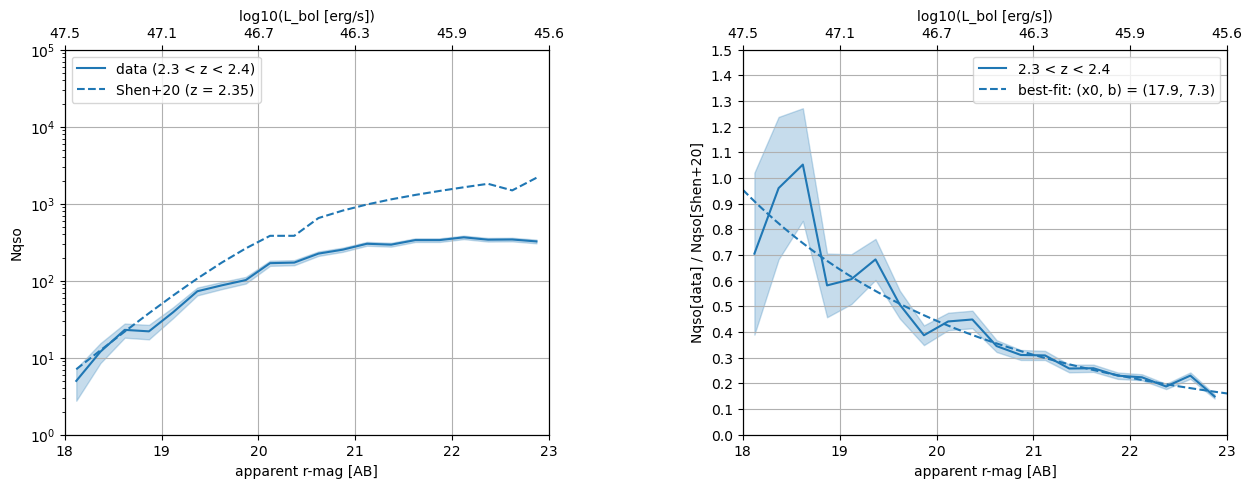


2.4 < z < 2.5


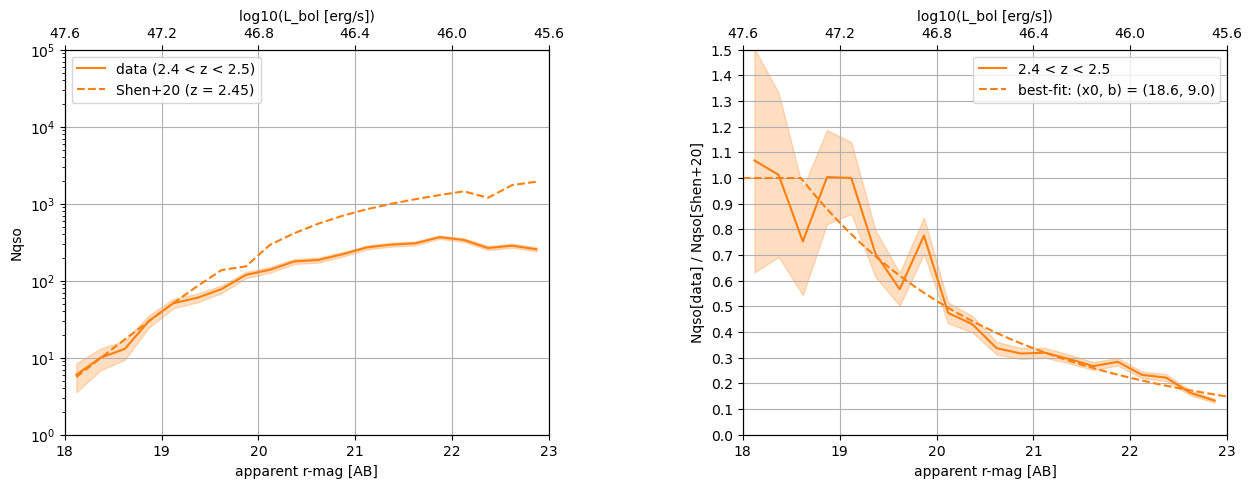


2.5 < z < 2.6


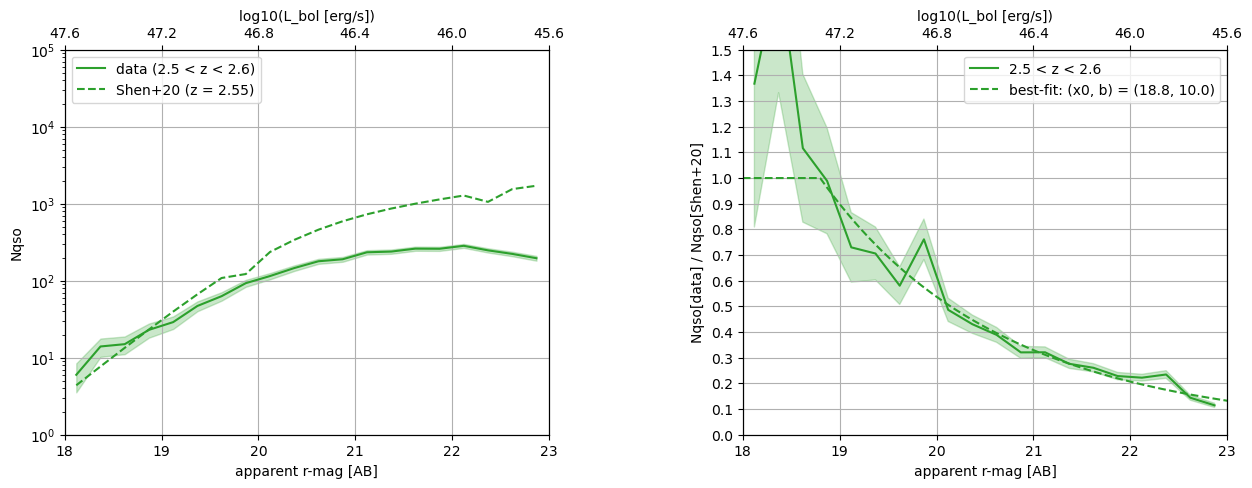


2.6 < z < 2.7


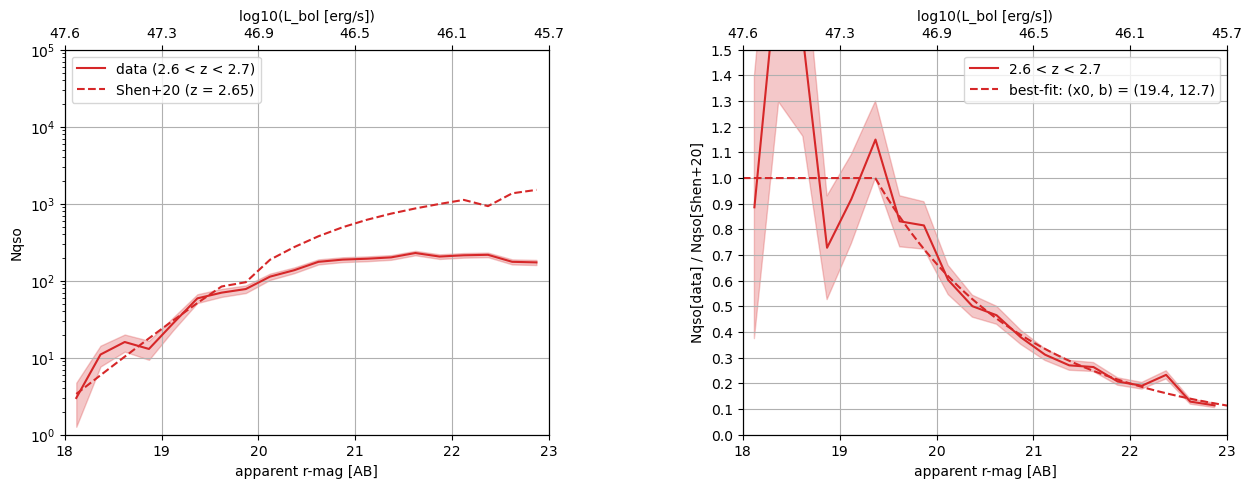


2.7 < z < 2.8


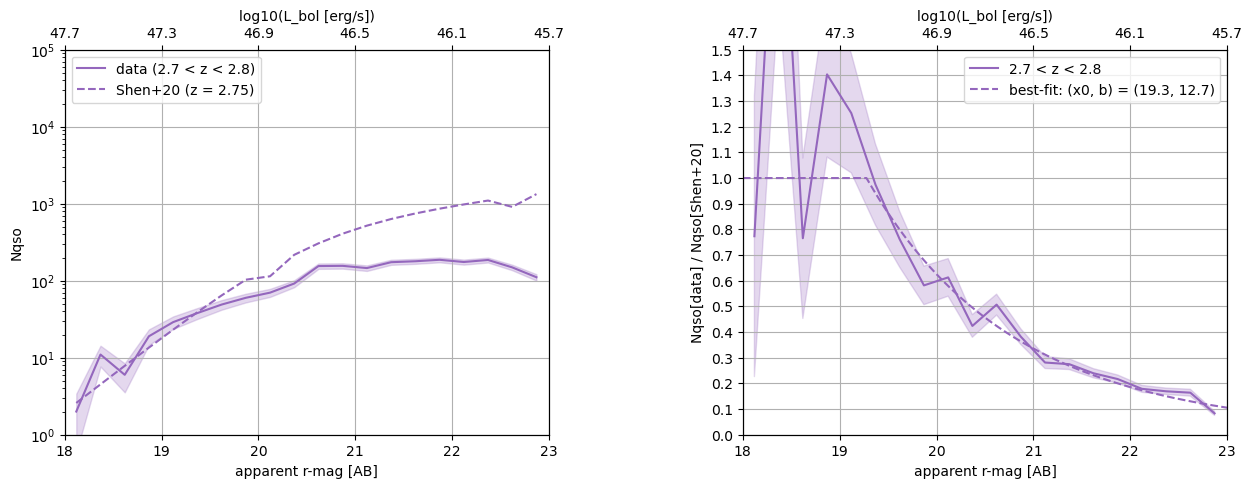


all redshifts: 2.3 < 2.8


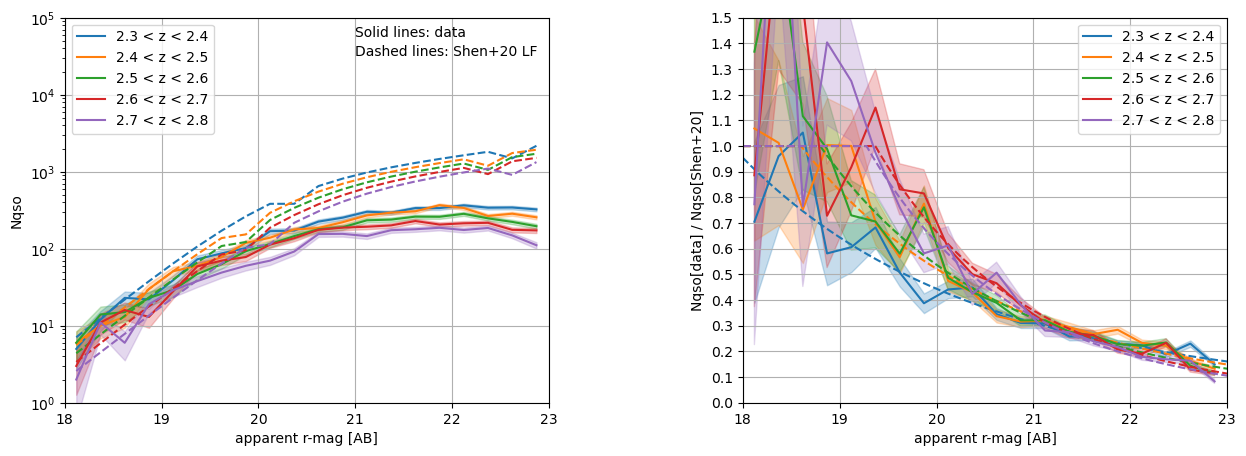


best fit parameters = f(z)


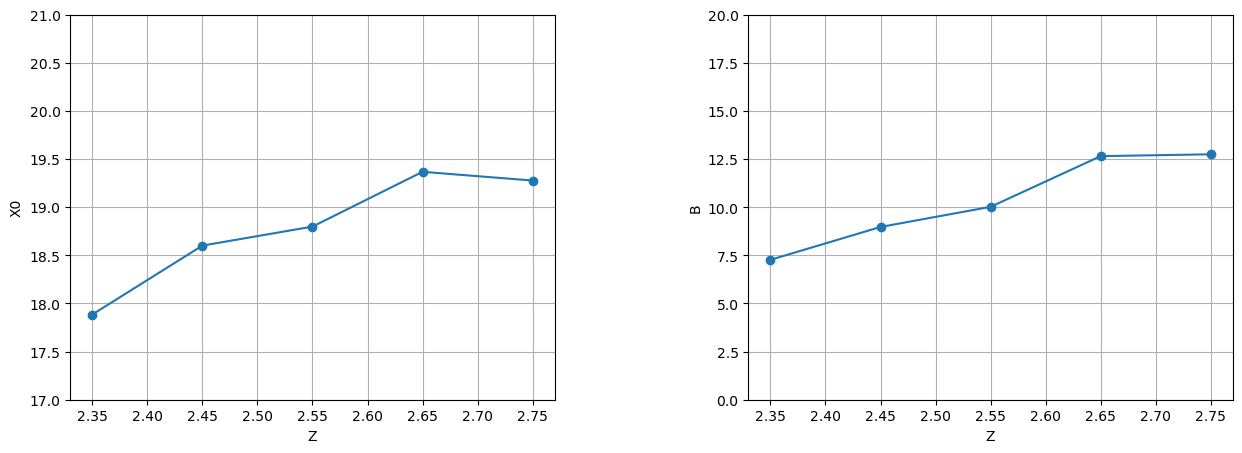

In [9]:
# luminosity function prediction
model_n = 0. * data_n

# fitted ratio parameters
d_fit = Table()
d_fit["ZMIN"], d_fit["ZMAX"] = zbins[:-1], zbins[1:]
d_fit["Z"] = 0.5 * (d_fit["ZMIN"] + d_fit["ZMAX"])
for key in fit_keys:
    d_fit[key] = np.zeros(len(zbins) - 1)

# volume estimation:
# - for each redshift bin, we take the volume of the shell
# - we correct for frac_area
vol = Planck18.comoving_volume(zbins).value
shell_vol = np.diff(vol)
shell_vol *= frac_area
print("shell_vol.shape = {}".format(shell_vol.shape))

L_bol_bins = np.logspace(30, 50, 1000)

# compute
for i in range(len(zbins) - 1):
    
    # get the L_bol corresponding to magbins for this redshift slice
    L_bol = appmag2Lbol(magbins, zcens[i])
    
    # get the Shen+20 LF prediction
    # N / d(log10(L)) / volume
    # integrate over each mag bin, ie log10(L_bol) bin
    for j in range(len(magbins) - 1):
        L_bol_bins_ij = L_bol_bins[(L_bol_bins > L_bol[j+1]) & (L_bol_bins < L_bol[j])]     
        model_phis = get_phis(L_bol_bins_ij, zcens[i], "shen20")
        model_n[i, j] = (
            np.trapz(model_phis, np.log10(L_bol_bins_ij))
            * shell_vol[i]
        )

    # fit
    ratios = data_n[i, :] / model_n[i, :]
    err_ratios = 1e99 + np.zeros(len(ratios))
    sel = data_n[i, :] > 0
    err_ratios[sel] = np.sqrt(data_n[i, sel]) / model_n[i, sel]
    popt, pcov = curve_fit(
        myfunc,
        magcens,
        ratios,
        sigma=err_ratios,
        p0=p0,
        bounds=bounds,
    )
    d_fit["X0"][i], d_fit["B"][i] = popt


# plot
cols = plt.rcParams["axes.prop_cycle"].by_key()["color"][:len(zbins)]
tmpmags = np.linspace(magmin, magmax, 1000)

for i in range(len(zbins) - 1):

    print("")
    print("{} < z < {}".format(zbins[i], zbins[i+1]))

    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(1, 2, wspace=0.4)                                                                                                                                                               

    # nqso
    ax = plt.subplot(gs[0])
    ax.plot(
        magcens,
        data_n[i, :],
        color=cols[i], label="data ({} < z < {})".format(zbins[i], zbins[i+1]))
    ax.fill_between(
        magcens,
        data_n[i, :] - err_data_n[i, :],
        data_n[i, :] + err_data_n[i, :],
        color=cols[i], alpha=0.25)
    ax.plot(magcens, model_n[i, :], color=cols[i], ls="--", label="Shen+20 (z = {})".format(zcens[i]))
    ax.set_xlabel("apparent {}-mag [AB]".format(band.lower()))
    ax.set_ylabel("Nqso")
    ax.set_xlim(magbins[0], magbins[-1])
    ax.set_ylim(1e0, 1e5)
    ax.set_yscale("log")
    ax.grid()
    ax.legend(loc=2)
    add_L_bol_axis(ax, zcens[i])

    # ratio
    ax = plt.subplot(gs[1])
    ax.plot(
        magcens,
        data_n[i, :] / model_n[i, :],
        color=cols[i], label="{} < z < {}".format(zbins[i], zbins[i+1]))
    ax.fill_between(
        magcens,
        (data_n[i, :] - err_data_n[i, :]) / model_n[i, :],
        (data_n[i, :] + err_data_n[i, :]) / model_n[i, :],
        color=cols[i], alpha=0.25,
    )
    tmpys = myfunc(tmpmags, d_fit["X0"][i], d_fit["B"][i])
    ax.plot(tmpmags, tmpys, color=cols[i], ls="--", label="best-fit: (x0, b) = ({:.1f}, {:.1f})".format(d_fit["X0"][i], d_fit["B"][i]))
    ax.set_xlabel("apparent {}-mag [AB]".format(band.lower()))
    ax.set_ylabel("Nqso[data] / Nqso[Shen+20]")
    ax.set_xlim(magbins[0], magbins[-1])
    ax.set_ylim(0, 1.5)
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    ax.grid()
    ax.legend(loc=1)
    add_L_bol_axis(ax, zcens[i])

    plt.show()

# all redshift bins together
print("")
print("all redshifts: {} < {}".format(zmin, zmax))

fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 2, wspace=0.4)                                                                                                                                                               
ax0 = plt.subplot(gs[0]) # nqso
ax1 = plt.subplot(gs[1]) # ratio
ax0.text(0.6, 0.95, "Solid lines: data", transform=ax0.transAxes)
ax0.text(0.6, 0.90, "Dashed lines: Shen+20 LF", transform=ax0.transAxes)
for i in range(len(zbins) - 1):
    
    ax0.plot(
        magcens,
        data_n[i, :],
        color=cols[i], label="{} < z < {}".format(zbins[i], zbins[i+1]))
    ax0.fill_between(
        magcens,
        data_n[i, :] - err_data_n[i, :],
        data_n[i, :] + err_data_n[i, :],
        color=cols[i], alpha=0.25)
    ax0.plot(magcens, model_n[i, :], color=cols[i], ls="--")
    ax0.set_xlabel("apparent {}-mag [AB]".format(band.lower()))
    ax0.set_ylabel("Nqso")
    ax0.set_xlim(magbins[0], magbins[-1])
    ax0.set_ylim(1e0, 1e5)
    ax0.set_yscale("log")
    ax0.grid()
    ax0.legend(loc=2)

    # ratio
    ax1.plot(
        magcens,
        data_n[i, :] / model_n[i, :],
        color=cols[i], label="{} < z < {}".format(zbins[i], zbins[i+1]))
    ax1.fill_between(
        magcens,
        (data_n[i, :] - err_data_n[i, :]) / model_n[i, :],
        (data_n[i, :] + err_data_n[i, :]) / model_n[i, :],
        color=cols[i], alpha=0.25,
    )
    tmpys = myfunc(tmpmags, d_fit["X0"][i], d_fit["B"][i])
    ax1.plot(tmpmags, tmpys, color=cols[i], ls="--")
    ax1.set_xlabel("apparent {}-mag [AB]".format(band.lower()))
    ax1.set_ylabel("Nqso[data] / Nqso[Shen+20]")
    ax1.set_xlim(magbins[0], magbins[-1])
    ax1.set_ylim(0, 1.5)
    ax1.yaxis.set_major_locator(MultipleLocator(0.1))
    ax1.grid()
    ax1.legend(loc=1)

plt.show()

# best fit parameters = f(z)
print("")
print("best fit parameters = f(z)")
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, len(fit_keys), wspace=0.4)                                                                                                                                                               
for ip, key in enumerate(fit_keys):
    ax = fig.add_subplot(gs[ip])
    ax.plot(d_fit["Z"], d_fit[key], "-o")
    ax.set_xlabel("Z")
    ax.set_ylabel(key)
    ax.set_ylim(bounds[0][ip], bounds[1][ip])
    ax.grid()
plt.show()

